## State Summaries From Electricity Data

### Initial Setup

In [1]:
import os, sys
import pprint as p
import pyspark.sql.functions as pysF
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px

%matplotlib widget
%matplotlib inline

py_file_path = os.path.join(
    os.getcwd(),
    "..",
    ".."
)

sys.path.append(py_file_path)
from app.SparkTools import MyPySpark

MySpark = None

#ensure only one sc and spark instance is running
global MySpark
MySpark = MySpark or MyPySpark(
    master = 'local[3]', 
    logger_name = 'jupyter')

### Filter and Join Data

In [2]:
p.pprint(
    list(
        set(
            MySpark\
            .spark\
            .read\
            .parquet("/Processed/ElectricityDimDF")\
            .select("value_type")
            .toPandas()["value_type"])))

['Retail sales of electricity',
 'Fossil-fuel stocks for electricity generation',
 'Revenue from retail sales of electricity',
 'Average cost of fossil fuels for electricity generation',
 'MMBtu per unit',
 'Consumption for electricity generation (Btu)',
 'Receipts of fossil fuels by electricity plants',
 'Electric fuel consumption quantity',
 'Electric fuel consumption MMBtu',
 'Average retail price of electricity',
 'Number of customer accounts',
 'Net generation',
 'Consumption for useful thermal output',
 'Fuel consumption quantity',
 'Average cost of fossil fuels for electricity generation (per Btu)',
 'Total consumption (Btu)',
 'Fuel consumption MMBtu',
 'Quality of fossil fuels in electricity generation',
 'Consumption for useful thermal output (Btu)',
 'Receipts of fossil fuels by electricity plants (Btu)',
 'Total consumption',
 'Consumption for electricity generation']


In [3]:
electricity_dim_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityDimDF")\
    .select("series_id", "state", "fuel_type", "engine_type", "units")\
    .filter(
        (pysF.col("value_type") == 'Fuel consumption MMBtu') &
        (pysF.col("engine_type") == 'all primemovers'))\
    .withColumn(
        "fuel_type",
        pysF.regexp_replace(
            pysF.regexp_replace(
                pysF.col("fuel_type"),
                "[^a-zA-Z0-9\s]", 
                ""),
            "\s",
            "_"))

electricity_fact_df = MySpark\
    .spark\
    .read\
    .parquet("/Processed/ElectricityFactDF")

electricity_df = electricity_fact_df.join(
    pysF.broadcast(electricity_dim_df),
    on = "series_id",
    how = "right"
)

In [4]:
fuel_types_l = electricity_df\
    .select("fuel_type")\
    .distinct()\
    .rdd.map(lambda x: x[0])\
    .collect()

electricity_pivoted_summary_df = electricity_df\
    .groupBy("date", "state")\
    .pivot("fuel_type")\
    .agg(pysF.sum("value"))\
    .fillna(
        0, 
        subset=[i for i in fuel_types_l if i])\
    .drop("null")\
    .withColumn(
        "other",
        pysF.col("all_fuels") - sum(pysF.col(i) for i in fuel_types_l if i and i != "all_fuels"))

In [5]:
electricity_formatted_df = MySpark.melt(
    df = electricity_pivoted_summary_df,
    id_vars = ["date", "state"],
    value_vars = [i for i in fuel_types_l if i and i != "all_fuels"],
    var_name = 'fuel_type')

In [11]:
# make treemap of state -> fuels, and fuels -> states
# maybe group fuels to make less subcategories

state_2019_df = electricity_formatted_df\
    .filter(
        (pysF.year("date") == "2019") & 
        (pysF.col("value") > 0))\
    .groupBy("state", "fuel_type")\
    .agg(pysF.sum("value").alias("consumption"))\
    .withColumn("all", pysF.lit("all"))

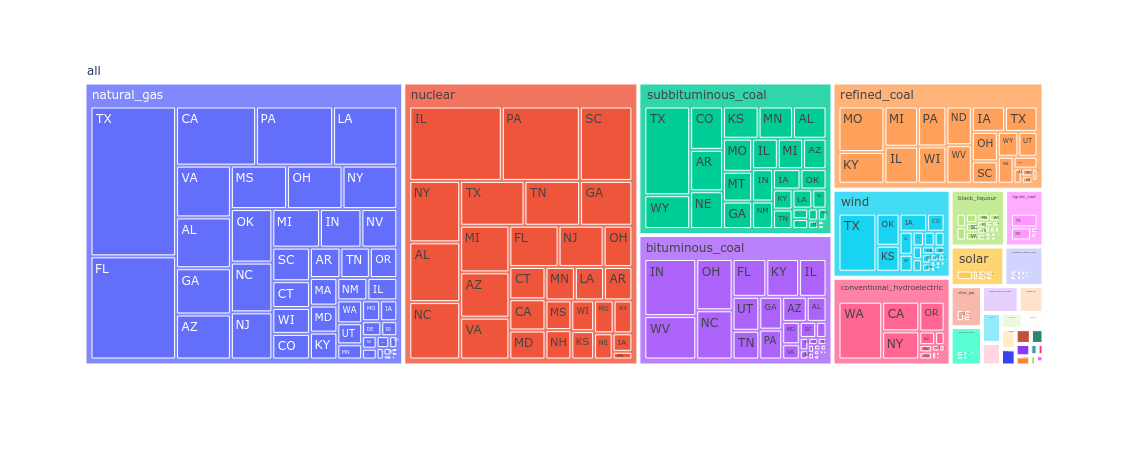

In [12]:
fig = px.treemap(
    data_frame = state_2019_df.toPandas(),
    names = "fuel_type",
    values = "consumption",
    path = ["all", "fuel_type", "state"]
)
fig.show()

In [26]:
#get list of fuels and group together
# state_2019_df\
#     .select("fuel_type")\
#     .distinct()\
#     .rdd\
#     .map(lambda x: x[0])\
#     .collect()

electricity_formatted_reduced_df = electricity_formatted_df\
    .withColumn(
        "fuel_type",
        pysF.when(
            pysF.col("fuel_type").rlike(".*_coal$"),
            "coal")\
        .otherwise(
            pysF.when(
                (pysF.col("fuel_type").isin([
                    "geothermal",
                    "solar",
                    "wind"])) |
                (pysF.col("fuel_type").rlike(".*hydroelectric.*")), 
                "renewable")
            .otherwise(
                pysF.when(
                    pysF.col("fuel_type").isin(["natural_gas","nuclear"]), 
                    pysF.col("fuel_type"))
                .otherwise("other"))))
    
state_2019_reduced_df = electricity_formatted_reduced_df\
    .filter(
        (pysF.year("date") == "2019") & 
        (pysF.col("value") > 0))\
    .groupBy("state", "fuel_type")\
    .agg(pysF.sum("value").alias("consumption"))\
    .withColumn("all", pysF.lit("all"))

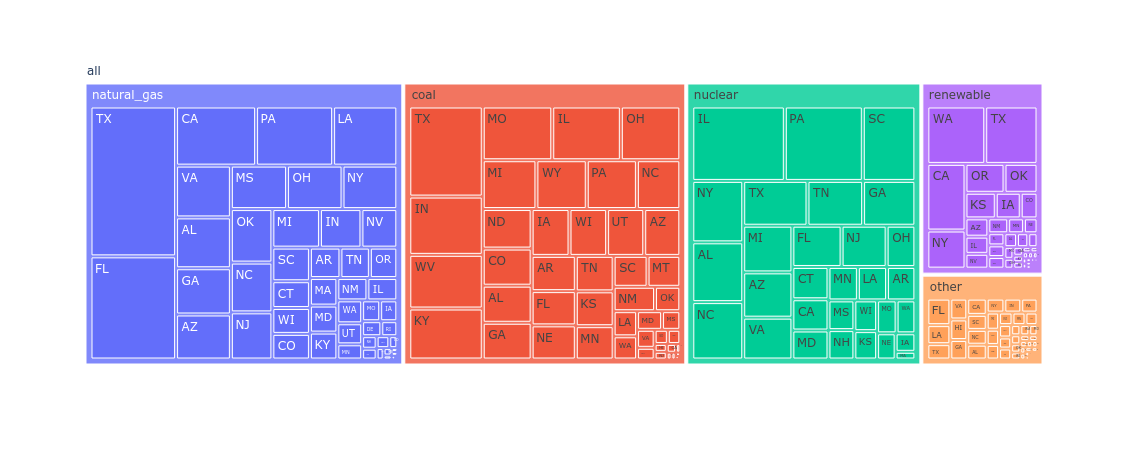

In [27]:
fig = px.treemap(
    data_frame = state_2019_reduced_df.toPandas(),
    names = "fuel_type",
    values = "consumption",
    path = ["all", "fuel_type", "state"]
)
fig.show()

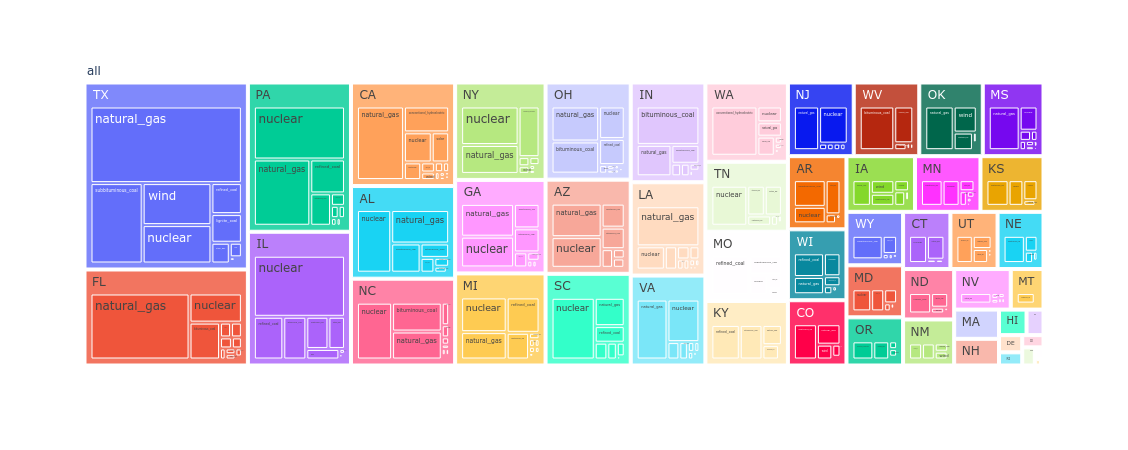

In [28]:
fig = px.treemap(
    data_frame = state_2019_df.toPandas(),
    names = "fuel_type",
    values = "consumption",
    path = ["all", "state", "fuel_type"]
)
fig.show()

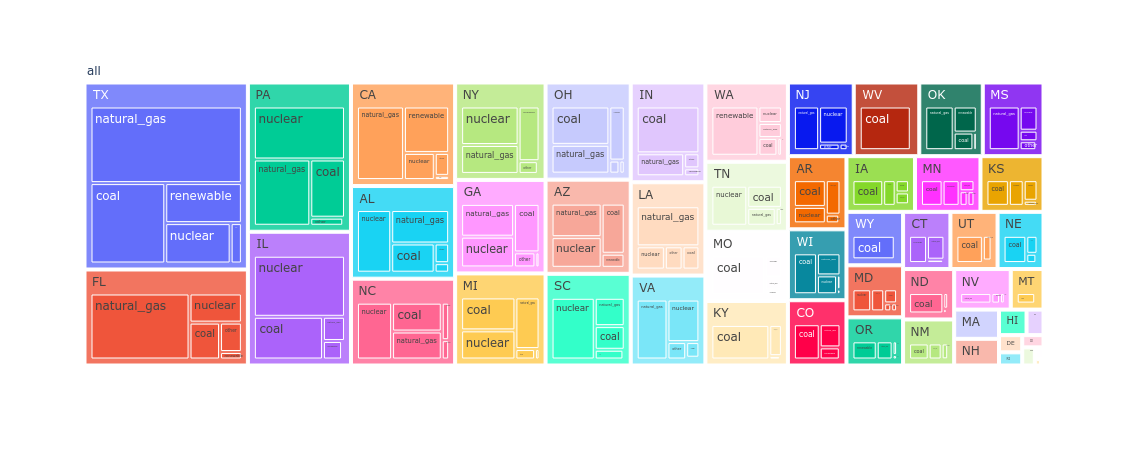

In [91]:
fig = px.treemap(
    data_frame = state_2019_reduced_df.toPandas(),
    names = "fuel_type",
    values = "consumption",
    path = ["all", "state", "fuel_type"]
)
fig.show()

In [117]:
from pyspark.sql.window import Window as pysW
# 5 year average centered at 5 years ago
state_fuel_5_year_windowspec = pysW\
    .partitionBy("state", "fuel_type")\
    .orderBy("year")\
    .rowsBetween(-7, -3)

In [119]:
state_consumption_diff_df = electricity_formatted_reduced_df\
    .withColumn(
        "year",
        pysF.year("date"))\
    .groupBy(
        "year",
        "state", 
        "fuel_type")\
    .agg(pysF.sum("value").alias("consumption"))\
    .withColumn(
        "consumption_diff",
        pysF.col("consumption") - pysF.avg(pysF.col("consumption")).over(state_fuel_5_year_windowspec))\
    .orderBy("state", "fuel_type", "year")

state_2019_diff_reduced_increase_df = state_consumption_diff_df\
    .select("year", "state", "fuel_type", "consumption_diff")\
    .filter(
        (pysF.col("year") == "2019") & 
        (pysF.col("consumption_diff").isNotNull()) &
        (pysF.col("consumption_diff")>0))\
    .withColumn("all", pysF.lit("all"))

state_2019_diff_reduced_decrease_df = state_consumption_diff_df\
    .select("year", "state", "fuel_type", "consumption_diff")\
    .filter(
        (pysF.col("year") == "2019") & 
        (pysF.col("consumption_diff").isNotNull()) &
        (pysF.col("consumption_diff")<0))\
    .withColumn(
        "consumption_diff",
        pysF.col("consumption_diff") * -1)\
    .withColumn("all", pysF.lit("all"))

In [120]:
state_consumption_diff_df.filter((pysF.col("state") == "CO") & (pysF.col("fuel_type") == "renewable")).show(20)

+----+-----+---------+--------------------+--------------------+
|year|state|fuel_type|         consumption|    consumption_diff|
+----+-----+---------+--------------------+--------------------+
|2001|   CO|renewable|       2.493187176E7|                null|
|2002|   CO|renewable|       1.888283133E7|                null|
|2003|   CO|renewable|       1.442543728E7|                null|
|2004|   CO|renewable|1.4386187530000001E7|      -1.054568423E7|
|2005|   CO|renewable|2.2496890360000003E7|   589538.8150000013|
|2006|   CO|renewable|         2.6355977E7|   6942596.876666665|
|2007|   CO|renewable|         2.9881863E7|1.1725281024999999E7|
|2008|   CO|renewable|         5.2014577E7|3.2989933347999997E7|
|2009|   CO|renewable|         4.7968744E7|        2.86592793E7|
|2010|   CO|renewable|          4.956267E7|      2.8053398966E7|
|2011|   CO|renewable|         6.6195444E7|      3.7168345022E7|
|2012|   CO|renewable|         7.2537216E7|      3.6793605728E7|
|2013|   CO|renewable|   

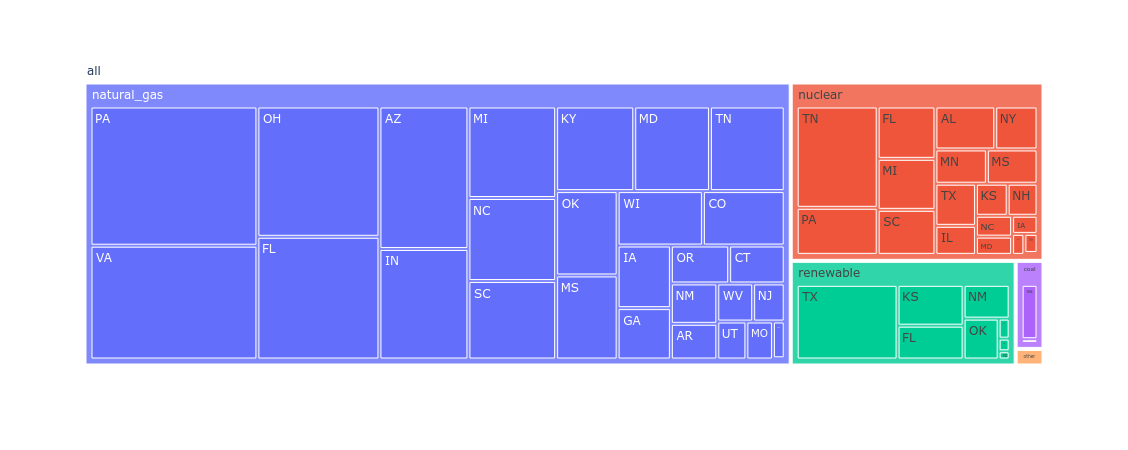

In [121]:
fig = px.treemap(
    data_frame = state_2019_diff_reduced_increase_df.toPandas(),
    names = "fuel_type",
    values = "consumption_diff",
    path = ["all", "fuel_type", "state"]
)
fig.show()

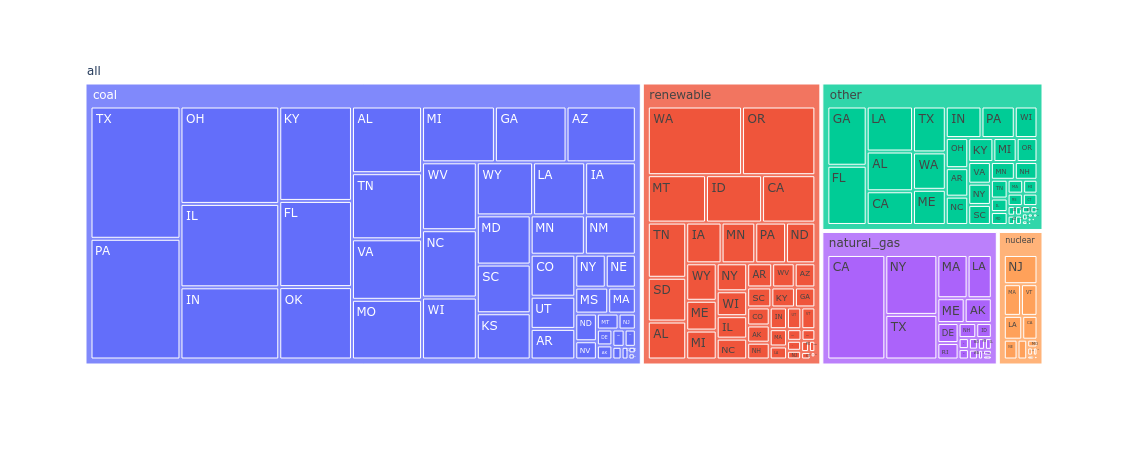

In [122]:
fig = px.treemap(
    data_frame = state_2019_diff_reduced_decrease_df.toPandas(),
    names = "fuel_type",
    values = "consumption_diff",
    path = ["all", "fuel_type", "state"]
)
fig.show()

In [9]:
state_df = electricity_formatted_df\
    .groupBy("date","state")\
    .agg(pysF.sum("value").alias("consumption"))\

state_l = state_df\
    .groupBy("state")\
    .agg(pysF.max("consumption").alias("max_consumption"))\
    .sort(pysF.col("max_consumption").desc())\
    .rdd\
    .map(lambda x: x["state"])\
    .collect()

print(state_l)

#do top 10, next 10, etc to break it up in subplots

# fig, axs = plt.subplots(1, 1, figsize=(16,30))
# fig.tight_layout()
# axs = sns.lineplot(
#     x = "date",
#     y = "consumption",
#     hue = "state",
#     data = state_df
# )

['TX', 'CA', 'FL', 'PA', 'IL', 'GA', 'OH', 'NY', 'AL', 'NC', 'IN', 'MI', 'WA', 'LA', 'AZ', 'SC', 'TN', 'KY', 'VA', 'MO', 'WV', 'OK', 'WI', 'NJ', 'AR', 'MS', 'MN', 'IA', 'OR', 'MD', 'WY', 'KS', 'CO', 'MA', 'ND', 'UT', 'NV', 'NE', 'NM', 'CT', 'MT', 'ME', 'NH', 'ID', 'SD', 'DE', 'HI', 'AK', 'RI', 'VT', None, 'DC']


In [10]:
# Use formatted_df for plotting
# Also use over() to create percentages by year by state for relative plot.